## Import

In [1]:
import sys
sys.path.insert(0,'/data/workspace_files/')

In [2]:
import pickle

from Advance_plotting import Plotter
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet import ResNet50
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.xception import Xception
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
#from keras.layers.normalization import BatchNormalization
from keras.models import Model
import numpy as np
#from keras.utils import plot_model
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf

In [5]:
physical_devices = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## Constantes

In [3]:
WIDTH = 224
HEIGHT = 224
BATCH_SIZE = 32
#PATH_DIRECTORY_IMAGE = '/content/drive/MyDrive/Colab Notebooks/Training_Dataset_limited_b'
#PATH_DIRECTORY_IMAGE = '/content/drive/MyDrive/Colab Notebooks/Training_Dataset_augmented_b'
#PATH_DIRECTORY_IMAGE = '/content/drive/MyDrive/Colab Notebooks/Training_Organisation'
#PATH_DIRECTORY_IMAGE = '/content/drive/MyDrive/Colab Notebooks/Training_reduced'
#PATH_DIRECTORY_IMAGE = './Training_Augmented'

## Fonctions

In [4]:
def load_data(file_x, file_y):
    """
        Lecture des fichiers numpy de données
    """

    x = np.load('/data/workspace_files/Ocular_dataset/'+file_x)
    y = np.load('/data/workspace_files/Ocular_dataset/'+file_y)
    
    ohe = OneHotEncoder()
    y = ohe.fit_transform(y.reshape(-1,1)).toarray()
     
    return (x , y)

## Modele

### Definition objet

In [5]:

class TransferLearningNN:
    """
    Transfer Learning Convolutional Neural Network initialized with pretrained weights.

    :param model_type: nom des modeles de base pre-entrainées. Options: ['Xception', 'VGG16', 'VGG19', 'ResNet50', 'InceptionV3', 'InceptionResNetV2']
    :param output_map : list des cibles


    **Example**:

        model = TransferLearningNN(model_type='inception_v3', output_map=[0,1,2,3,4,5,6])
        model.fit(images, labels, validation_split=0.15)

    """

    def __init__(self, model_type, output_map, nb_neurons, nb_layers, dropout):
        self.training_history = None
        self.model_type = model_type
        self.output_map = output_map
        self.plotter = Plotter(['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Others'], model_type=self.model_type)
        self.y_pred = None
        self.X_test = None
        self.y_test = None
        self.validation_data = None
        self.defined_metrics = [tf.keras.metrics.CategoricalAccuracy(name='accuracy'),tf.keras.metrics.Precision(name='precision'),tf.keras.metrics.Recall(name='recall'),tf.keras.metrics.AUC(name='auc')]
        self._init_model(nb_neurons=nb_neurons, nb_layers=nb_layers, dropout_rate=dropout)

    def _init_model(self, nb_layers=1, nb_neurons=1000, dropout_rate=0.5, activation='relu'):
        """
        Initialisation du modele de base et ajout de la derniere couche du reseau
        :return:
        """
        base_model = self._get_base_model()
        for layer in base_model.layers:
            layer.trainable = True

        x = base_model.output
        x = GlobalAveragePooling2D()(x)
        x = Dense(1024, activation='relu', kernel_initializer='glorot_normal')(x)

        if nb_layers<1 :
            nb_layers = 1
        for i_layer in range(nb_layers):
            div = 2**i_layer
            if (nb_neurons // (div))<128:
                break
            x = Dense(nb_neurons//(div), activation=activation, kernel_initializer='glorot_normal')(x)
            if dropout_rate!=0.0:
                x = Dropout(rate=dropout_rate)(x)

        predictions = Dense(8, activation='softmax')(x)
        full_model = Model(inputs=base_model.input, outputs=predictions)

        self.model = full_model

    def _get_base_model(self):
        """
        :return: modele de base (extraction des features)
        """
        if self.model_type == 'inception_v3':
            return InceptionV3(weights='imagenet', include_top=False,input_shape=(HEIGHT, WIDTH, 3))
        elif self.model_type == 'xception':
            return Xception(weights='imagenet', include_top=False,input_shape=(HEIGHT, WIDTH, 3))
        elif self.model_type == 'vgg16':
            return VGG16(weights='imagenet', include_top=False,input_shape=(HEIGHT, WIDTH, 3))
        elif self.model_type == 'vgg19':
            return VGG19(weights='imagenet', include_top=False,input_shape=(HEIGHT, WIDTH, 3))
        elif self.model_type == 'resnet':
            return ResNet50(weights='imagenet', include_top=False,input_shape=(HEIGHT, WIDTH, 3))
        else:
            raise ValueError('Cannot find base model %s' % self.model_type)

    def fit(self, X_train, y_train, X_test, y_test, epochs=50):
        """
        Entrainement du reseau

        :param X_train: Tableau numpy avec les données (images) pour l'entrainement
        :param y_train: Tableau numpy avec les classes pour l'entrainement
        :param X_test: Tableau numpy avec les données (images) pour la validation
        :param y_test: Tableau numpy avec les classes pour la validation
        :param epochs: Nombre maximum d'iteration.
        """
        self.X_test = X_test
        self.y_test = y_test

        # optimizer
        optimize_adam = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-7)
        optimize_sgd = tf.keras.optimizers.SGD(learning_rate=0.001, decay=1e-6, momentum=0.9, nesterov=True)

        # compile
        self.model.compile(optimizer=optimize_sgd, loss='categorical_crossentropy', metrics=self.defined_metrics)
        
        # fit
        self.training_history = self.model.fit(x=X_train, y=y_train, epochs=epochs, verbose=1,
                                               callbacks=[ReduceLROnPlateau(), EarlyStopping(patience=2)],
                                               shuffle=True, validation_data=(X_test, y_test))
        
        # predict
        self.y_pred = self.model.predict(x=X_test)

    def plot_metrics(self):
        """
        Affiche la courbe d'apprentissage
        """
        self.plotter.plot_metrics(self.training_history)

    def get_training(self):
        """
        Retourne l'historique d'entrainement
        """
        return self.training_history

    def print_evaluation(self):
        """
        Affiche les metriques du modele sur le jeu de donne de test
        """
        results = self.model.evaluate(self.X_test, self.y_test, verbose=2)
        for name, value in zip(self.model.metrics_names, results):
            print(name, ': ', value)

        y_test_flat = self.y_test.flatten()
        y_pred_flat = self.y_pred.flatten()

        kappa = metrics.cohen_kappa_score(y_test_flat, y_pred_flat > 0.5)
        f1 = metrics.f1_score(y_test_flat, y_pred_flat > 0.5, average='micro')
        print('kappa: ', kappa)
        print('F1_score: ', f1)

    def plot_accuracy(self):
        self.plotter.plot_accuracy(self.training_history)

    def plot_confusion_matrix(self, y_true, y_pred):
        """
        Affiche la matrice de confusion
        """
        self.plotter.plot_confusion_matrix_generic(y_true=y_true, predictions= y_pred)
        
    def saveHist(self, path):
        """
        Sauvegarde de la courbe d'apprentissage
        """
        pickle.dump(self.training_history, open(path, 'wb'))

    def loadHist(self, path):
        self.training_history.history = np.load(path, allow_pickle='TRUE').item()


### Lecture des données (entrainement et validation)

In [6]:
(X_train, y_train)= load_data(file_x='X_train.npy', file_y='y_train.npy')
(X_test, y_test)= load_data(file_x='X_test.npy', file_y='y_test.npy')

X_train = X_train.astype('uint8')
X_test = X_test.astype('uint8')

y_test = y_test.astype('uint8')
y_train = y_train.astype('uint8')

### Entrainement

In [12]:
model = TransferLearningNN(model_type='xception', output_map=[0,1,2,3,4,5,6,7], nb_neurons=1024, nb_layers = 1, dropout = 0.4)

83697664/83683744 [==============================] - 3s 0us/step


In [13]:
model.fit(X_train, y_train, X_test, y_test, epochs = 40)

Epoch 2/40
570/570 [==============================] - 339s 595ms/step - loss: 0.9428 - accuracy: 0.6519 - precision: 0.8598 - recall: 0.4708 - auc: 0.9370 - val_loss: 0.7554 - val_accuracy: 0.7144 - val_precision: 0.8650 - val_recall: 0.5734 - val_auc: 0.9600 - lr: 0.0010
Epoch 3/40
570/570 [==============================] - 337s 591ms/step - loss: 0.5995 - accuracy: 0.7740 - precision: 0.8784 - recall: 0.6711 - auc: 0.9750 - val_loss: 0.5388 - val_accuracy: 0.7896 - val_precision: 0.8795 - val_recall: 0.7074 - val_auc: 0.9793 - lr: 0.0010
Epoch 4/40
570/570 [==============================] - 351s 615ms/step - loss: 0.3932 - accuracy: 0.8512 - precision: 0.9049 - recall: 0.7955 - auc: 0.9893 - val_loss: 0.4591 - val_accuracy: 0.8142 - val_precision: 0.8627 - val_recall: 0.7732 - val_auc: 0.9836 - lr: 0.0010
Epoch 5/40
570/570 [==============================] - 335s 587ms/step - loss: 0.2638 - accuracy: 0.9026 - precision: 0.9284 - recall: 0.8754 - auc: 0.9952 - val_loss: 0.4010 - val_a

### Sauvegarde modele

In [14]:
model.model.save('/data/workspace_files/Ocular_dataset/model_23_01_Xception.h5')

/opt/python/envs/default/lib/python3.8/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


### Analyse

#### Matrice de confusion

---


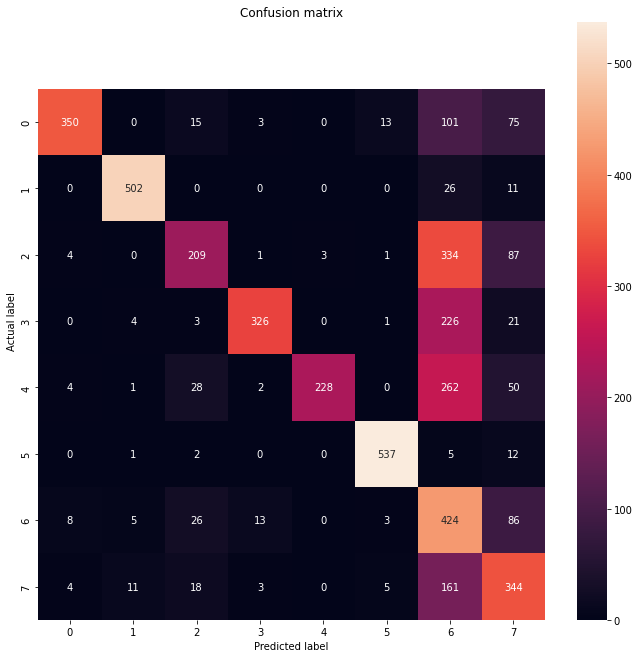

In [13]:
model.plot_confusion_matrix(y_true=y_test, y_pred=model.y_pred)

#### Courbe d'apprentissage

---

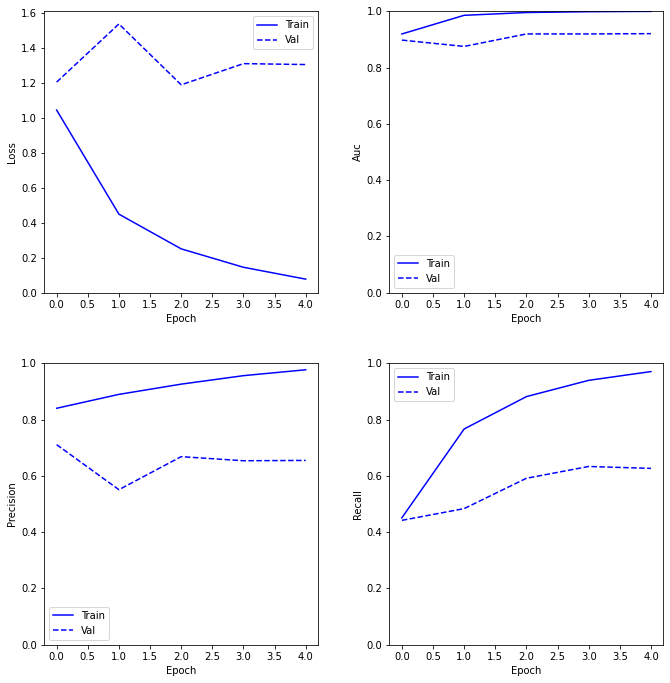

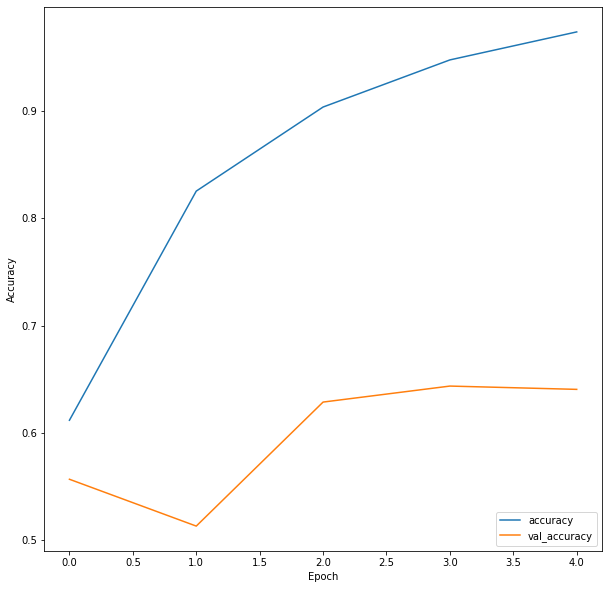

In [14]:
model.plot_metrics()
model.plot_accuracy()

#### Evaluation metrique

---


In [15]:
model.print_evaluation()

143/143 - 13s - loss: 1.3042 - accuracy: 0.6405 - precision: 0.6547 - recall: 0.6265 - auc: 0.9203 - 13s/epoch - 89ms/step
loss :  1.304237723350525
accuracy :  0.6404913067817688
precision :  0.6547455191612244
recall :  0.626453161239624
auc :  0.9202941060066223
kappa:  0.5901921971777025
F1_score:  0.9120146962053082


82/82 - 4s - loss: 0.4429 - accuracy: 0.9682 - precision: 0.8812 - recall: 0.8619 - auc: 0.9831 - 4s/epoch - 48ms/step
loss :  0.4428524971008301
accuracy :  0.968221127986908
precision :  0.8812426328659058
recall :  0.861923098564148
auc :  0.9830665588378906

In [17]:
from keras.utils.vis_utils import plot_model

plot_model(model=model.model, to_file='struct_net.png')

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


## Apprentissage multi-modele

Phase d'apprentissage de tous les modeles 

In [7]:
lst_model = [  'xception', 'inception_v3']
#'vgg19', 'resnet', 'vgg16',

def fit_all(X_train_, y_train_,X_test_, y_test_):
    dict_model_ = {}
    dict_training_ = {}
    for model_name in lst_model:
        model_ = TransferLearningNN(model_type=model_name, output_map=[0,1,2,3,4,5,6,7], nb_neurons=1024, nb_layers = 1, dropout = 0.4)
        model_.fit(X_train_, y_train_, X_test_, y_test_, epochs = 40)
        model_.model.save('/data/workspace_files/Ocular_dataset/model_03_02_'+model_name+'.h5')
        dict_model_[model_name] = model_
        dict_training_[model_name] = model_.get_training()
    return dict_model_, dict_training_

dict_model,  dict_training = fit_all(X_train, y_train,X_test, y_test)


87924736/87910968 [==============================] - 3s 0us/step
Epoch 1/40
570/570 [==============================] - 162s 268ms/step - loss: 1.3185 - accuracy: 0.5079 - precision: 0.8207 - recall: 0.3057 - auc: 0.8656 - val_loss: 1.1168 - val_accuracy: 0.5904 - val_precision: 0.7183 - val_recall: 0.4903 - val_auc: 0.9116 - lr: 0.0010
Epoch 2/40
570/570 [==============================] - 147s 257ms/step - loss: 0.7695 - accuracy: 0.7101 - precision: 0.8389 - recall: 0.5925 - auc: 0.9575 - val_loss: 0.7527 - val_accuracy: 0.7122 - val_precision: 0.8417 - val_recall: 0.6067 - val_auc: 0.9590 - lr: 0.0010
Epoch 3/40
570/570 [==============================] - 147s 258ms/step - loss: 0.5105 - accuracy: 0.8099 - precision: 0.8750 - recall: 0.7445 - auc: 0.9808 - val_loss: 0.7024 - val_accuracy: 0.7520 - val_precision: 0.8128 - val_recall: 0.7013 - val_auc: 0.9649 - lr: 0.0010
Epoch 4/40
570/570 [==============================] - 147s 258ms/step - loss: 0.3405 - accuracy: 0.8743 - precision:

/opt/python/envs/default/lib/python3.8/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
